<a href="https://colab.research.google.com/github/geoffwoollard/learn_cryoem_math/blob/master/nb/vacuum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
Build intuition for vacuum logic

# Resources
Vos, Matthijn. 2019. em-learning.com: Introduction to The Microscope: Vacuum Theory. 

VAC AERO International. 2018. The Fundamentals of Vacuum Theory
. https://vacaero.com/information-resources/vac-aero-training/170466-the-fundamentals-of-vacuum-theory.html

# Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


# Particle bounding around box

* Box of length $L_x, L_y$, launched out of corner with initial velocity $v$ and angle from the x-axis $\theta$
* Assumptions
  * elastic collisions with wall: every time we hit a wall in the x/y direction, the x(y) veloxity compotent switches (multipled by -1)
  * particle moves in stright line at constant velocity
* Intuitively a collision with the x/y wall happens every time $\Delta t_{x(y)}$. We can calculate whether we'll hit a x or y wall by calculating our locations afer both $\Delta t_{x}$ and $\Delta t_{y}$, and seeing which wall we'll hit first. 
* The x and y trajectories can be solved independently of each other, since they just oscilate back and forth. However, we are interested in the locations of the x(y) component when the particle hits the y(x) wall and changes y(x) velocity. These can be interpolated since the velocity is constant. See simulation.
* Analytically, we can 

* Simulation Algorithm:

In this case we can simply step though the times

In [4]:
n_hits = 10
Lx,Ly = 2,1
v=1
theta_deg=44

def comp_xy(n_hits,Lx,Ly,theta_deg,v):
  assert n_hits % 2 == 0 # even
  theta = theta_deg*np.pi/180.


  vxi,vyi = v*np.cos(theta), v*np.sin(theta)
  tx,ty = Lx/vxi, Ly/vyi

  hits = np.array([0,1]*(n_hits//2))
  n_hits_arr = np.arange(n_hits)
  y_df = pd.DataFrame({'t':ty*np.arange(0,n_hits), 'y':Ly*hits})
  x_df = pd.DataFrame({'t':tx*np.arange(0,n_hits), 'x':Lx*hits})
  t = min(y_df['t'].max(),x_df['t'].max())
  df = pd.merge(y_df,x_df, how='outer').sort_values('t').filter(['t','x','y'])
  df = df[df['t']< t]
  return(df)

df = comp_xy(n_hits,Lx,Ly,theta_deg,v)


In [7]:
def interpolate_xy(df,theta_deg,v):
  theta = theta_deg*np.pi/180.
  vx,vy = v*np.cos(theta), v*np.sin(theta)
  df = df.sort_values('t')
  
  for step in range(1,df.shape[0]):
    i = df.iloc[step]
    im1 = df.iloc[step-1]
    if np.isnan(i['y']):
      i['y'] = im1['y']+(i['t']-im1['t'])*vy
    else:
      vy *= -1
    if np.isnan(i['x']):
      i['x'] = im1['x']+(i['t']-im1['t'])*vx
    else:
      vx *= -1
  return(df)
df = interpolate_xy(df,theta_deg,v)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  """Entry point for launching an IPython kernel.


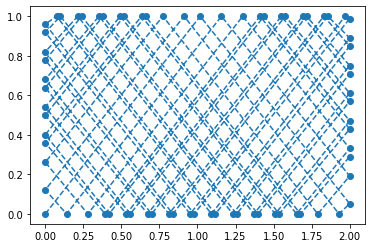

In [150]:
plt.plot( 'x', 'y', data=df, linestyle='dashed', marker='o')


# Particle excaping box


##  Analytical solution to expected escape time
* since the x and y compotent are independent of each other, we can simply compute the liklihood of exiting the box as a multipolicative probability 
* If the escape location is on the bottom of the x wall, then the y location needs to be zero, and the x location has to be inside the slit.
$$P(\text{escape}) = P(y=0, x_{slit_i} < x < x_{slit_f}) \\
P(y=0)P(x_{slit_i} < x < x_{slit_f})
$$
* We can calclate the slit probability based on the ratio of the slit size to the box length: $P(x_{slit_i} < x < x_{slit_f}) = \frac{x_{slit_i}-x_{slit_f}}{L_x} = \Delta x_{slit} / L_x$
* The excape time is computed by the time it takes the event to happen, multipled by its probability. We can just define $P(y=0)$ zero except when we are at $y=0$, in which case it is unity. Thus we can compute the expected escape time
$$E[t_{escape}] = \sum_{\text{i s.t. y=0}}t_{i}P(\text{escape on i, didn't escape before)} \\
= \sum_{\text{i s.t. y=0}}t_{i}P(\text{escape on i}) P(\text{didn't escape before)} \\
= \sum_i 2t_yip(1-p)^i \ \text{assuming independence}\\
= 2t_yp\sum_i i(1-p)^i \\
= 2t_y(1-p)/p \\
= 2t_y(L_x-\Delta x_{slit})/\Delta x_{slit} \\
= 2t_y(N-1)
= \frac{2}{500 \sin\theta}(10^3-1) s \approx 4/\sin\theta \ s
$$
  * $P(\text{escape on i})=p$
  * $L_x = N\Delta x_{slit}$
  * $\sum_i i(1-p)^i = (1-p)/p^2$, from [Wolfram](https://www.wolframalpha.com/input/?i=infinite+sum+of+i*%281-p%29%5Ei)
  * $N=1/10^{-3} = 10^3$ for a small slit (1 m box, 1 mm slit)
  * $t_y = Ly / v_y = \frac{1}{500}s$ for a $L_y=1m$ and $v$ about 500 m/s (see [here](https://pages.mtu.edu/~suits/SpeedofSound.html#:~:text=For%20typical%20air%20at%20room,is%20lost%20during%20the%20collisions.))

## Simulation
|`theta_deg`|`n_hits`|compute time `interpolate_xy(df)` (s)|escape.sum()|simulated escape time (s)|analytical escape time (s); $4/\sin \theta$|
|-|-|-|-|-|-|
|10|86824|26.8|7|14.6|23|
|10|34026|10.5|3|14.6|23|
|40|321392|2min 33s|135|5.2|6.2|
|40|3000|1.47|1|2.4|6.2|
|40|7150|3.42|3|2.4|6.2|
|87.5|9990|2.72|4|3.09|4.0|
|87.5|6000|1.63|2|3.09|4.0|
|2.5|9990|2.78|0|-|91.7|
|2.5|137422|37.5|0|-|91.7|
|2.5|1374224|6min 11s|30|524|91.7|


<!-- |87.5|999048|4min 40s|67|
|2.5|218096|||| -->

In [194]:
Lx,Ly = 1,1
v=500
theta_deg=40
theta = theta_deg*np.pi/180.
vxi,vyi = v*np.cos(theta), v*np.sin(theta)
tx,ty = Lx/vxi, Ly/vyi
n_hits = 3*4/(np.sin(theta)*min(tx,ty)) # because if not enough xhits, will drop computed y hits, so need to simulate up to this time
n_hits = int(2*(n_hits //2)) # round to even
n_hits, n_hits*min(tx,ty)


(7150, 18.667324237451584)

In [195]:
4/np.sin(theta)

6.22289530744165

In [196]:
%%time
df = comp_xy(n_hits,Lx,Ly,theta_deg,v)


CPU times: user 32.1 ms, sys: 1 ms, total: 33.1 ms
Wall time: 34.2 ms


In [197]:
%%time
df = interpolate_xy(df,theta_deg,v)

CPU times: user 3.49 s, sys: 2 ms, total: 3.5 s
Wall time: 3.5 s


In [137]:
dxslit=1e-3
xslit_i, xslit_f = Lx/2-dxslit/2, Lx/2+dxslit/2
xslit_i, xslit_f 

(0.4995, 0.5005)

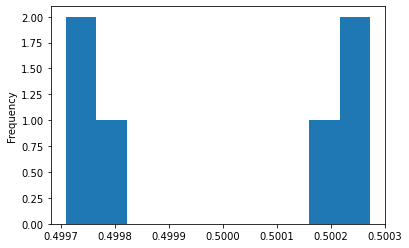

In [198]:
xs = pd.Series(df['x'].value_counts().index[2:].sort_values().values)
idx=(.4995 < xs)&(xs < 0.5005) # for both y O and Ly, so double
xs[idx].plot.hist()

We can check the distribution, and see if it is indeed uniform. Or if certain areas are more likely to be hit than others.

In [199]:
escape = (df['y'] == 0)&(xslit_i < df['x'])&(df['x'] < xslit_f)
escape.sum()

3

Our simulation time needs to be long enough to observe an event

In [178]:
df['t'].iloc[np.argmax(escape)]

14.558171781387108

And here we see what the simulation computes for an excape time. This is exact, and can be repeated for many initial conditions (angle, location, etc), to compute an empirical expectation.

### Average Excape Time over Angles

#### Analytical
We can repexpress our analytical expression for the $E[t_{escape}]$ as a function of $\theta$, since $t_y(\theta) = L_y/v_y = L_y / (v\sin\theta)$. If the distibution over starting angles is uniform we have:
$$
E_\theta[t_{escape}] = 2(N-1)L_y/v\int_\epsilon^{\pi/2-\epsilon} d\theta \frac{1}{\sin\theta}
$$

Care is taken to avoid $\theta=0,\pi$ since the particle would bounce in the same line and never escape. We therefore give it at least some small angle $\epsilon$. 

Wolfram gives the integral of $1/\sin\theta$ as $\log[\tan\theta/2]$. Using the small angle approx (Taylor expansion about 0 and $\pi/2$ to first order of $\epsilon$), we get $$
f(\epsilon) = \int_\epsilon^{\pi/2-\epsilon} d\theta \frac{1}{\sin\theta}
 = \log[2(1/\epsilon-1)] \\
f(\epsilon=1^{\circ} \approx 0.017) = 5 \\
f(\epsilon=0.1^{\circ} \approx 0.0017) = 7
 $$
 
 Putting it together, we get
 $$
 E_\theta[t_{escape}] = 2(N-1)L_y/v \log[2(1/\epsilon-1)]
 $$

 

Text(0, 0.5, 'Expected escape time (s)')

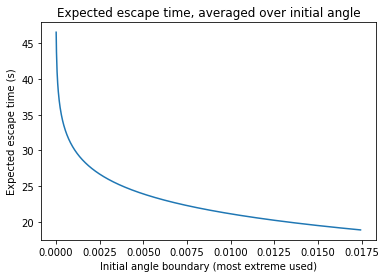

In [228]:
Lx,Ly = 1,1
v=500
dxslit=1e-3
N=Ly/dxslit
es = np.pi/180*np.arange(0.001,1,0.001)


escape_t_avangles = 2*(N-1)*Ly/v*np.log(2*(1/es-1))
sr = pd.Series(escape_t_avangles)
sr.index = es
sr.plot(title='Expected escape time, averaged over initial angle')
plt.xlabel('Initial angle boundary (most extreme used)')
plt.ylabel('Expected escape time (s)')

This means 


We can see how our simulations and analytical predictions correlate for various angles. For computational simplicity we can first average over angles from ~2.5 to 90 in 5 deg steps, and start from the corner of the box. We avoid a small angle, and especialy zero (it will never get out, as the y coordinate will not change).

In [ ]:
Lx,Ly = 1,1
v=500

dxslit=1e-3
xslit_i, xslit_f = Lx/2-dxslit/2, Lx/2+dxslit/2
theta_degs = np.arange(0.1,1,0.1).tolist() + np.arange(1,10,1).tolist() + np.arange(10,90,3).tolist() 
theta_degs = np.array(theta_degs)
escape_ts = np.zeros(theta_degs.shape[0])
escape_ts_analytical = np.zeros(theta_degs.shape[0])

vxi,vyi = v*np.cos(theta), v*np.sin(theta)
tx,ty = Lx/vxi, Ly/vyi

for theta_deg_idx in range(theta_degs.shape[0]):
  theta_deg = theta_degs[theta_deg_idx]
  theta = theta_deg*np.pi/180.
  vxi,vyi = v*np.cos(theta), v*np.sin(theta)
  tx,ty = Lx/vxi, Ly/vyi
  n_hits = 10*4/(np.sin(theta)*min(tx,ty)) # because if not enough xhits, will drop computed y hits, so need to simulate up to this time
  n_hits = int(2*(n_hits //2)) # round to even
  df = comp_xy(n_hits,Lx,Ly,theta_deg,v)
  df = interpolate_xy(df,theta_deg,v)
  escape = (df['y'] == 0)&(xslit_i < df['x'])&(df['x'] < xslit_f)
  if escape.sum() == 0:
    escape_ts[theta_deg_idx] = np.nan
  else:
    escape_ts[theta_deg_idx] = df['t'].iloc[np.argmax(escape)]
  escape_ts_analytical[theta_deg_idx] = 4/np.sin(theta)


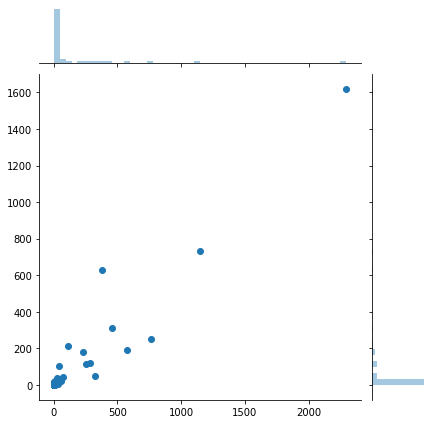

In [230]:
escape_ts_analytical = 4/np.sin(np.pi*theta_degs/180)
g = sns.jointplot(x=escape_ts_analytical, y=escape_ts)


In [232]:
escape_ts_analytical.mean(), escape_ts.mean()

(162.88839359932246, 107.92038579794755)

In [231]:
escape_ts_analytical, escape_ts

(array([2291.83234408, 1145.91791737,  763.94721751,  572.96244937,
         458.37205392,  381.97884483,  327.41259937,  286.4882062 ,
         254.65838122,  229.19475399,  114.61483339,   76.42929044,
          57.3423481 ,   45.89485298,   38.26708893,   32.82203619,
          28.74118614,   25.56981289,   23.03508193,   17.78164593,
          14.51182111,   12.28621395,   10.67786865,    9.46480633,
           8.52021787,    7.76641611,    7.1531666 ,    6.64656056,
           6.22289531,    5.86511674,    5.56065436,    5.30005197,
           5.07607286,    4.88309836,    4.71671361,    4.57341627,
           4.45040776,    4.34544151,    4.25671109,    4.18276703,
           4.12245452,    4.07486678,    4.03931029,    4.01527935,
           4.00243818]),
 array([1.62032547e+03, 7.33387467e+02, 2.53630476e+02, 1.89077608e+02,
        3.08942764e+02, 6.26063327e+02, 4.97667151e+01, 1.22616952e+02,
        1.13322980e+02, 1.79230298e+02, 2.12610516e+02, 4.63925793e+01,
        2.1

Deviations can be caused by, among other things, the unique initial condition (in the corner). For many angles, there would be a initial location where the particle would escape very quickly. In analogy to billiards, if you were aiming for a pocket, and could place the ball anywhere (but had to shoot it in a given direction), you could probably find a location to get it in the pocket, especially if you could bank it off the side of the table many times.

### Average over starting location
The expectation should average over configurations (starting spots). Instead of varrying the starting location, which would increase the simulation time, we can simualte always from the corner, and then average over where the slit location is.